In [17]:
import glob
import matplotlib.pyplot as plt
import IPython
import tensorflow as tf
import seaborn as sns
import numpy as np
import pydub
import wave
import math

from pydub.playback import play
from scipy.io import wavfile
tf.enable_eager_execution()

In [18]:
audio_files = glob.glob("../data/raw/positives/*/*.wav")
audio_file = audio_files[1]
IPython.display.Audio(audio_file)

In [3]:
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

def graph_spectrogram(wav_file, nfft=512, fs=2, noverlap=256):
    """
    Calculate and plot spectrogram for a wav audio file
    :param wav_file:
    :param nfft: Length of each window segment
    :param fs: Sampling frequencies
    :param noverlap: Overlap between windows
    :return:
    """
    rate, data = get_wav_info(wav_file)
    nchannels = data.ndim

    if nchannels > 1:
        data = data[:, 0]

    pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap=noverlap)

    return pxx

array([[2.23608535e+04, 2.38686715e+03, 4.06013749e+02, ...,
        1.72154990e+04, 2.86462390e+05, 1.35556574e+03],
       [5.46536735e+04, 2.00875051e+05, 1.66215005e+05, ...,
        1.61520672e+05, 2.90579919e+05, 5.44119862e+05],
       [1.29505001e+05, 2.07979203e+05, 2.42254272e+05, ...,
        4.31890609e+05, 2.02087474e+05, 7.32028718e+05],
       ...,
       [7.85009447e-02, 3.44814495e-02, 7.07368123e-04, ...,
        1.39296116e-01, 2.35190460e-02, 6.94050735e-02],
       [5.00784500e-03, 1.29587995e-01, 5.83077824e-02, ...,
        2.73216778e-01, 2.83419708e-02, 4.30602443e-02],
       [1.08001903e-02, 8.07957197e-02, 3.58239239e-02, ...,
        2.09728240e-01, 3.17552644e-02, 6.06218703e-04]])

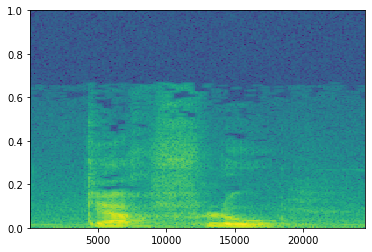

In [4]:
graph_spectrogram(audio_file)

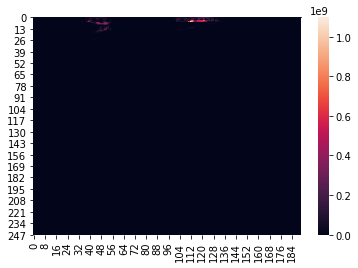

In [5]:
sns.heatmap(graph_spectrogram(audio_file))

In [6]:
sampling_rate = 16000

In [8]:
sns.heatmap(np.swapaxes(magnitude_spectrograms.numpy()[0],0,1))

NameError: name 'magnitude_spectrograms' is not defined

In [196]:
def convert_audio_i_to_spectro_i(i, audio_length, frame_length, frame_step):
    spectro_length = audio_length // frame_length * (frame_length / frame_step) + (audio_length % frame_length) // frame_step - 1
    return int(spectro_length * i / audio_length)

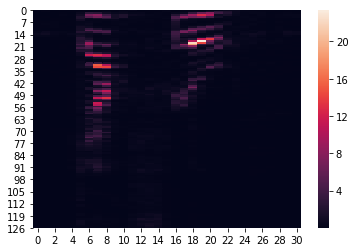

In [141]:
sns.heatmap(np.swapaxes(mel_spectrograms.numpy()[0],0,1))

In [200]:
convert_audio_i_to_spectro_i(51, 16000, 1024, 512)

0

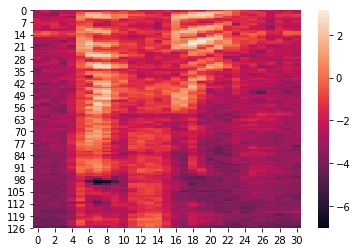

In [142]:
sns.heatmap(np.swapaxes(log_mel_spectrograms.numpy()[0],0,1))

In [215]:
convert_audio_ito_spec_i(16, 1024, 512)

-1

In [226]:
audio_binary = tf.read_file(audio_file)
waveform = tf.contrib.ffmpeg.decode_audio(audio_binary, file_format='wav', samples_per_second=sampling_rate, channel_count=1)
signals = tf.reshape(waveform[:16000], [1, -1])
stfts = tf.contrib.signal.stft(signals, 
                               frame_length=1024, 
                               frame_step=512,
                               fft_length=1024)
magnitude_spectrograms = tf.abs(stfts)

num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80, 8000, 128

linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sampling_rate, lower_edge_hertz,
    upper_edge_hertz)

mel_spectrograms = tf.tensordot(
    magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

log_offset = 1e-6
log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

num_mfccs = 20
# Keep the first `num_mfccs` MFCCs.
mfccs = tf.contrib.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :num_mfccs]
print("waveform" , waveform.numpy().shape)
print("signals" , signals.numpy().shape)
print("magnitude_spectrograms" , magnitude_spectrograms.numpy().shape)
print("mel_spectrograms" , mel_spectrograms.numpy().shape)
print("log_mel_spectrograms" , log_mel_spectrograms.numpy().shape)
print("mfccs" , mfccs.numpy().shape)

waveform (16416, 1)
signals (1, 16000)
magnitude_spectrograms (1, 30, 513)
mel_spectrograms (1, 30, 128)
log_mel_spectrograms (1, 30, 128)
mfccs (1, 30, 20)


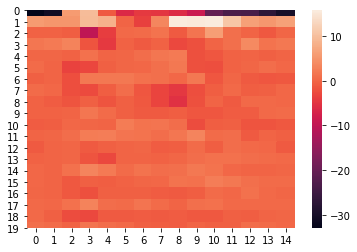

In [138]:
sns.heatmap(np.swapaxes(mfccs.numpy()[0],0,1))

In [69]:
tf.contrib.ffmpeg.

<module 'tensorflow.contrib.ffmpeg' from '/Users/az01640/Projets/multrigger-word/.venv/lib/python3.6/site-packages/tensorflow/contrib/ffmpeg/__init__.py'>

In [19]:
sampling_rate = 16000
positive = tf.read_file(audio_file)
positive = tf.contrib.ffmpeg.decode_audio(positive, file_format='wav', samples_per_second=sampling_rate, channel_count=1)

W0829 10:33:41.414412 140734872815040 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0829 10:33:41.426367 140734872815040 deprecation.py:323] From <ipython-input-19-9b1acff0d025>:3: decode_audio (from tensorflow.contrib.ffmpeg.ffmpeg_ops) is deprecated and will be removed after 2018-09-04.
Instructions for updating:
tf.contrib.ffmpeg will be removed in 2.0, the support for video and audio will continue to be provided in tensorflow-io: https://github.com/tensorflow/io


In [37]:
hash(positive) % 2**32

1148620136

In [34]:
2**32

4294967296

In [67]:
positive.numpy().min(), positive.numpy().max()

(-6.092898274800973e-06, 7.146256393752992e-06)

In [68]:
min(positive_audio) / (2**15), max(positive_audio) / (2**15)

(-0.200408935546875, 0.234130859375)

In [47]:
positive_audio = pydub.AudioSegment.from_file(audio_file).get_array_of_samples()
min(positive_audio), max(positive_audio)

(-6567, 7672)

In [61]:
positive_audiosegment = pydub.AudioSegment(positive.numpy().tobytes(), 
                                           frame_rate=sampling_rate, channels=1, 
                                           sample_width=positive.numpy().dtype.itemsize)
positive_audiosegment = np.array(positive_audiosegment.get_array_of_samples('f'))
positive_audiosegment

array([-0.00091556, -0.00051881,  0.00030519, ...,  0.00314341,
        0.00167852,  0.00167852], dtype=float32)

In [ ]:
tf.

In [284]:
positive_pydub.mean()

-3.5948611111111113

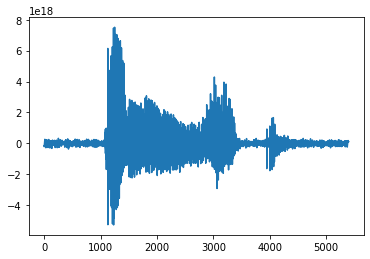

In [282]:
matplotlib.pyplot.plot(positive_pydub)

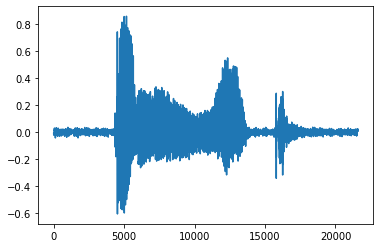

In [214]:
matplotlib.pyplot.plot(positive.numpy())

In [112]:
test_audiosegment = pydub.AudioSegment(test.eval(),
                                       frame_rate=sampling_rate, channels=1,
                                       sample_width=test.eval().dtype.itemsize)

NameError: name 'test' is not defined

In [15]:
np.random.seed(1)
print(np.random.randn())
print(np.random.randn())
print(np.random.randn())
print(np.random.randn())
print(np.random.randn())
print(np.random.randn())

1.6243453636632417
-0.6117564136500754
-0.5281717522634557
-1.0729686221561705
0.8654076293246785
-2.3015386968802827


In [88]:
play(positive_audiosegment)

In [ ]:
play(test_audiosegment)

In [5]:
tf.InteractiveSession()

In [30]:
def get_dBFS(sound_array):
    sound_array_int = np.frombuffer(sound_array.tobytes(),dtype=np.int32)
    sound_array_rms = math.sqrt(np.sum(np.square(positive_int.astype(np.int64))/ positive_int.shape[0]))
    bits = sound_array_int.dtype.itemsize * 8
    max_possible_amplitude = (2 ** bits) / 2
    ratio = positive_rms / max_possible_amplitude
    dBFS = 20 * math.log(ratio, 10)
    return dBFS

In [31]:
def match_target_amplitude(sound, target_dBFS):
    """
    Used to standardize volume of audio clip
    :param sound: sound to standardize in numpy array from tensor
    :param target_dBFS: targeted volume
    :return: standardized sound
    """
    change_in_dBFS = target_dBFS - get_dBFS(sound)
    return sound * 10 ** (change_in_dBFS / 20)

array([[ 0.00134325],
       [ 0.00123946],
       [ 0.00105628],
       ...,
       [-0.0004274 ],
       [-0.00042129],
       [-0.00026865]], dtype=float32)

In [37]:
changed_positive = match_target_amplitude(positive.eval(), -20)
pydub.AudioSegment(changed_positive.tobytes(), frame_rate=16000, channels=1, sample_width=changed_positive.dtype.itemsize)


NameError: name 'positive' is not defined

In [354]:
10 ** (db / 20)

-6.023432162407067

In [36]:
np.array(positive_audiosegment.get_array_of_samples())

NameError: name 'positive_audiosegment' is not defined

In [258]:
positive_int = np.frombuffer(positive.eval().tobytes(),dtype=np.int32)
positive_rms = math.sqrt(np.sum(np.square(positive_int).astype(np.uint64)) / positive_int.shape[0])
bits = positive_int.dtype.itemsize
max_possible_amplitude = (2 ** bits) / 2
ratio = positive_rms/max_possible_amplitude
positive_dBFS = 20 * math.log(ratio, 10)

In [227]:
random_start = np.random.randint(low=0, high=test.eval().shape[0] - positive.eval().shape[0])
random_end = test.eval().shape[0] - positive.eval().shape[0] - random_start
padded_positive = np.pad(positive.eval(), ((random_start,random_end), (0,0)))
positive.eval().shape, test.eval().shape, padded_positive.shape

((11776, 1), (95915, 1), (95915, 1))

In [261]:
positive_int

array([ 1004274104,  1003159958,  1001193818, ..., -1156841192,
       -1156972268, -1162870432], dtype=int32)

In [267]:
test

In [259]:
positive_rms

39578647.85940018

In [266]:
test = pydub.AudioSegment(positive.eval().tobytes(), frame_rate=16000, channels=1, sample_width=positive.eval().dtype.itemsize)
test.rms, test.max_possible_amplitude, test.rms / test.max_possible_amplitude


(1073391761, 2147483648.0, 0.4998369892127812)

In [115]:
sound = test.eval() + np.pad(positive.eval(), ((random_start,random_end), (0,0))) * 10

In [116]:
play(pydub.AudioSegment(sound.tobytes(), frame_rate=16000, channels=1, sample_width=sound.dtype.itemsize))

In [113]:
IPython.display.Audio(audio_files[3])

In [20]:
positive

NameError: name 'positive' is not defined

In [32]:
match_target_amplitude(pydub.AudioSegment.from_wav(audio_file), -20)

AttributeError: 'AudioSegment' object has no attribute 'tobytes'

In [34]:
np.pydub.AudioSegment.from_wav(audio_file).get_array_of_samples()

array('h', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, -2, -3, -3, -1, 2, 2, 2, 4, 4, 2, -2, -4, 0, 4, 6, 10, 18, 16, 4, -7, -10, 0, 7, 1, -7, -9, -13, -20, -24, -21, -11, -7, -14, -18, -11, -2, 1, 1, 7, 19, 31, 33, 30, 34, 33, 24, 13, 8, 6, 5, 3, -1, -3, -4, -10, -21, -31, -34, -29, -18, -9, -3, 5, 6, -3, -10, -21, -34, -32, -24, -12, 2, 17, 9, -9, -1, 2, -10, -15, -24, -23, -11, -42, -72, -53, -80, -118, -58, -10, 16, 30, -22, -28, 24, 38, 40, 68, 71, 70, 65, 23, 20, 44, 33, 22, 3, -8, 13, 96, 225, 281, 249, 244, 294, 295,